In [3]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/summary/Golden_summary_reduced.xlsx


tokenizer_config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/648M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Input ids are automatically padded from 7441 to 8192 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 5765 to 6144 to be a multiple of `config.attention_window`: 1024


Epoch 1 - Training Loss: 4.5305
Epoch 1 - Validation Loss: 2.2798
Epoch 2 - Training Loss: 3.7819
Epoch 2 - Validation Loss: 2.0876
Epoch 3 - Training Loss: 3.3141
Epoch 3 - Validation Loss: 1.9559
Epoch 4 - Training Loss: 2.6411
Epoch 4 - Validation Loss: 1.7208
Epoch 5 - Training Loss: 2.0424
Epoch 5 - Validation Loss: 1.6217


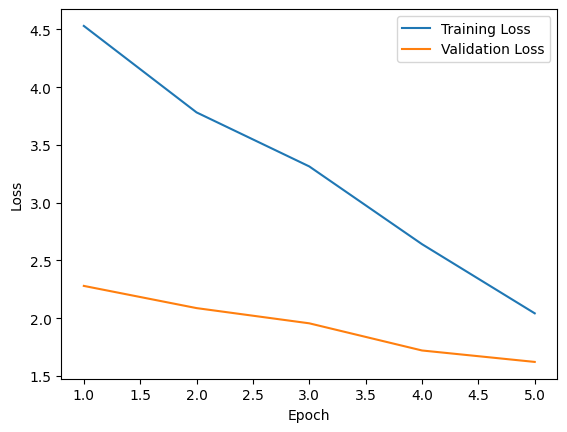

Input ids are automatically padded from 4612 to 5120 to be a multiple of `config.attention_window`: 1024


Target: "The appellant, a cooperative society, filed an appeal against a judgment delivered by the High Court of Rajasthan. The case involved the amalgamation of four cooperative societies into the appellant society. The appellant sought to carry forward the accumulated losses of the amalgamated societies and set them off against its profits, but the assessing officer denied the claim. The CIT (Appeals) and the Income Tax Appellate Tribunal also dismissed the appeals. The appellant argued that the amalgamated societies' rights to carry forward losses continued under Section 16(8) of the Rajasthan Co-operative Societies Act, but the court disagreed. It held that since the amalgamated societies ceased to exist, they could not file tax returns or carry forward losses. The court interpreted the tax statute strictly and emphasized that there is no equity in tax matters. The appeal was ultimately dismissed."
Prediction: "The appellant society has appealed against the judgment delivered on 19

In [4]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
import matplotlib.pyplot as plt

def generate_prediction(model, tokenizer, input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt', max_length=None, truncation=True)
    input_ids = input_ids.to(device)

    outputs = model.generate(input_ids=input_ids, max_length=50, num_beams=4, early_stopping=True)
    predictions = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return predictions

# Step 1: Load the Dataset
df = pd.read_excel("/kaggle/input/summary/Golden_summary_reduced.xlsx")

# Step 2: Split the Dataset into Train, Test, and Validation Sets
train_text, test_text, train_summary, test_summary = train_test_split(
    df['Judgment'], df['Golden summary'], test_size=0.2, random_state=42
)
test_text, val_text, test_summary, val_summary = train_test_split(
    test_text, test_summary, test_size=0.5, random_state=42
)

tokenizer = AutoTokenizer.from_pretrained("nsi319/legal-led-base-16384")
model = AutoModelForSeq2SeqLM.from_pretrained("nsi319/legal-led-base-16384")

# Step 4: Tokenize the Data
train_encodings = tokenizer(list(train_text), truncation=True, padding=True)
train_labels = tokenizer(list(train_summary.astype(str)), truncation=True, padding=True)

val_encodings = tokenizer(list(val_text), truncation=True, padding=True)
val_labels = tokenizer(list(val_summary.astype(str)), truncation=True, padding=True)

test_encodings = tokenizer(list(test_text), truncation=True, padding=True)
test_labels = tokenizer(list(test_summary.astype(str)), truncation=True, padding=True)

# Step 5: Create PyTorch Datasets
class SummaryDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels['input_ids'][idx])
        return item

    def __len__(self):
        return len(self.labels['input_ids'])

train_dataset = SummaryDataset(train_encodings, train_labels)
val_dataset = SummaryDataset(val_encodings, val_labels)
test_dataset = SummaryDataset(test_encodings, test_labels)

# Step 6: Fine-tune the Legal-Led Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

optimizer = AdamW(model.parameters(), lr=1e-5)

num_epochs = 5

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} - Training Loss: {avg_loss:.4f}")

    # Step 7: Evaluation on Validation Set
    model.eval()

    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}")

# Plotting the losses
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 8: Generate Predictions on Test Set
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=50)
        batch_preds = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outputs]
        predictions.extend(batch_preds)

# Step 9: Evaluate Predictions
test_summary_list = test_summary.tolist()

for i in range(len(predictions)):
    print(f"Target: {test_summary_list[i]}")
    print(f"Prediction: {predictions[i]}")
    print("=" * 5)


In [5]:
# Step 8: Generate Predictions on Test Set
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=200)
        batch_preds = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outputs]
        predictions.extend(batch_preds)


# Step 9: Evaluate Predictions
test_summary_list = test_summary.tolist()

for i in range(len(predictions)):
    print(f"Target: {test_summary_list[i]}")
    print(f"Prediction: {predictions[i]}")
    print("=" * 5)
    

Target: "The appellant, a cooperative society, filed an appeal against a judgment delivered by the High Court of Rajasthan. The case involved the amalgamation of four cooperative societies into the appellant society. The appellant sought to carry forward the accumulated losses of the amalgamated societies and set them off against its profits, but the assessing officer denied the claim. The CIT (Appeals) and the Income Tax Appellate Tribunal also dismissed the appeals. The appellant argued that the amalgamated societies' rights to carry forward losses continued under Section 16(8) of the Rajasthan Co-operative Societies Act, but the court disagreed. It held that since the amalgamated societies ceased to exist, they could not file tax returns or carry forward losses. The court interpreted the tax statute strictly and emphasized that there is no equity in tax matters. The appeal was ultimately dismissed."
Prediction: "The appellant society has appealed against the judgment delivered on 19

In [6]:
model_save_path = "/kaggle/working/Legal Led base_model_gsd.h5"
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: /kaggle/working/Legal Led base_model_gsd.h5


In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW
from torch.utils.data import DataLoader, Dataset

df = pd.read_excel("/kaggle/input/summary1/Golden_summary.xlsx")


test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False)

predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)


        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=200)
        batch_preds = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outputs]
        predictions.extend(batch_preds)

predictions_df = pd.DataFrame({'Target Summary': test_summary_list, 'Predicted Summary': predictions})

predictions_df.to_excel("/kaggle/working/LegalLed_Predicted_summaries.xlsx", index=False)


In [7]:
!pip install rouge
from rouge import Rouge

references = []
hypotheses = []

for i in range(len(predictions)):
    reference = test_summary_list[i]
    hypothesis = predictions[i]
    references.append(reference)
    hypotheses.append(hypothesis)

rouge = Rouge()
scores = rouge.get_scores(hypotheses, references, avg=True)

rouge_1_score = scores['rouge-1']
rouge_2_score = scores['rouge-2']
rouge_l_score = scores['rouge-l']

print(f"ROUGE-1 Score: {rouge_1_score}")
print(f"ROUGE-2 Score: {rouge_2_score}")
print(f"ROUGE-L Score: {rouge_l_score}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ROUGE-1 Score: {'r': 0.34285714285714286, 'p': 0.3691451031772027, 'f': 0.3532649065392133}
ROUGE-2 Score: {'r': 0.1602297895902547, 'p': 0.16927083333333331, 'f': 0.1627777728426668}
ROUGE-L Score: {'r': 0.31936813186813184, 'p': 0.343432689158205, 'f': 0.32887103475578333}


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

references = test_summary_list
hypotheses = predictions


tfidf_vectorizer = TfidfVectorizer()
vectorized_references = tfidf_vectorizer.fit_transform(references)
vectorized_hypotheses = tfidf_vectorizer.transform(hypotheses)


cosine_similarities = cosine_similarity(vectorized_references, vectorized_hypotheses)


average_cosine_similarity = np.mean(cosine_similarities)


print(f"Average Cosine Similarity: {average_cosine_similarity:.4f}")


Average Cosine Similarity: 0.6497
